# Convolutional Neural Network

This example shows how to design a simple quantization aware training CNN and how to measure 
the maximum accumulator bit width. We also show the impact of quantization on accuracy. 

To analyze the potential FHE-compatible quantization configurations, we use the simulation mode of
 the FHE circuit of the CNN. The maximum accumulator 
bit width that is currently allowed in Concrete ML is **16** bits, which limits the bit-widths 
that are usable for weights and activations.

We find an FHE compatible configuration for 3 bits weights and activations and run the CNN in FHE.
The accuracy in this highly quantized configuration is 92%. 

### Import required modules

In [1]:
import time

import numpy as np
import torch
import torch.utils
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn.utils import prune
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from concrete.ml.torch.compile import compile_brevitas_qat_model

# And some helpers for visualization.

%matplotlib inline

import matplotlib.pyplot as plt

### Load the data-set and visualize it

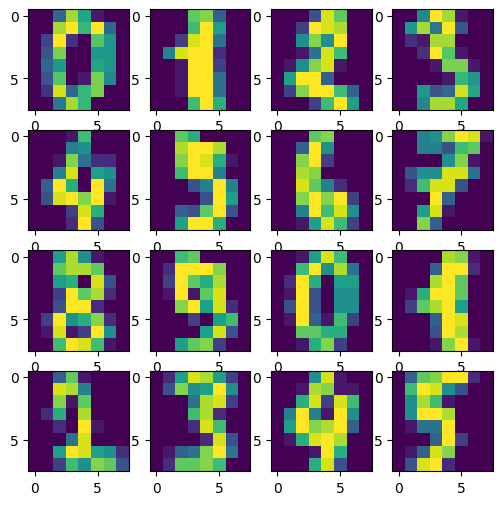

In [2]:
X, y = load_digits(return_X_y=True)

# The sklearn Digits data-set, though it contains digit images, keeps these images in vectors
# so we need to reshape them to 2D first. The images are 8x8 px in size and monochrome
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

nplot = 4
fig, ax = plt.subplots(nplot, nplot, figsize=(6, 6))
for i in range(0, nplot):
    for j in range(0, nplot):
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())
plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

### Define the neural network

Since the accumulator bit width in FHE is small, we prune the convolutional
filters to limit the number of connections per neuron.

Neural network **pruning** is the process by which the synapses of individual neurons in a layer
are forced to have a weight equal to zero. This basically eliminates them from the computation 
and thus they do not increase the accumulator bit width. It has been shown that neural networks can 
maintain their accuracy with a degree of pruning that can 
even exceed 70% for some over-parametrized networks such as VGG16 or large ResNets.

See: https://arxiv.org/pdf/2003.03033.pdf, Figure 8 in Section 7.2, for an evaluation on the 
simple pruning method used in this example.

In [3]:
import brevitas.nn as qnn


class TinyCNN(nn.Module):
    """A very small CNN to classify the sklearn digits data-set.

    This class also allows pruning to a maximum of 10 active neurons, which
    should help keep the accumulator bit width low.
    """

    def __init__(self, n_classes, n_bits) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        a_bits = n_bits
        w_bits = n_bits

        # This network has a total complexity of 1216 MAC
        self.q1 = qnn.QuantIdentity(bit_width=a_bits, return_quant_tensor=True)
        self.conv1 = qnn.QuantConv2d(1, 8, 3, stride=1, padding=0, weight_bit_width=w_bits)
        self.q2 = qnn.QuantIdentity(bit_width=a_bits, return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(8, 16, 3, stride=2, padding=0, weight_bit_width=w_bits)
        self.q3 = qnn.QuantIdentity(bit_width=a_bits, return_quant_tensor=True)
        self.conv3 = qnn.QuantConv2d(16, 32, 2, stride=1, padding=0, weight_bit_width=w_bits)
        self.q4 = qnn.QuantIdentity(bit_width=a_bits, return_quant_tensor=True)
        self.fc1 = qnn.QuantLinear(
            32,
            n_classes,
            bias=True,
            weight_bit_width=w_bits,
        )

        # Enable pruning, prepared for training
        self.toggle_pruning(True)

    def toggle_pruning(self, enable):
        """Enables or removes pruning."""

        # Maximum number of active neurons (i.e., corresponding weight != 0)
        n_active = 12

        # Go through all the convolution layers
        for layer in (self.conv1, self.conv2, self.conv3):
            s = layer.weight.shape

            # Compute fan-in (number of inputs to a neuron)
            # and fan-out (number of neurons in the layer)
            st = [s[0], np.prod(s[1:])]

            # The number of input neurons (fan-in) is the product of
            # the kernel width x height x inChannels.
            if st[1] > n_active:
                if enable:
                    # This will create a forward hook to create a mask tensor that is multiplied
                    # with the weights during forward. The mask will contain 0s or 1s
                    prune.l1_unstructured(layer, "weight", (st[1] - n_active) * st[0])
                else:
                    # When disabling pruning, the mask is multiplied with the weights
                    # and the result is stored in the weights member
                    prune.remove(layer, "weight")

    def forward(self, x):
        """Run inference on the tiny CNN, apply the decision layer on the reshaped conv output."""

        x = self.q1(x)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.q2(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.q3(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.q4(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

### Train the CNN

Note that the training code for quantization aware training is the same as it would be for
floating point training. Indeed, the Brevitas layers used in the CNN class will handle
quantization during training. 

We train the network for varying weights and activations bit-width, to find an FHE compatible 
configuration.

Training with 6 bit weights and activations: 100%|██████████| 150/150 [00:16<00:00,  9.18it/s]


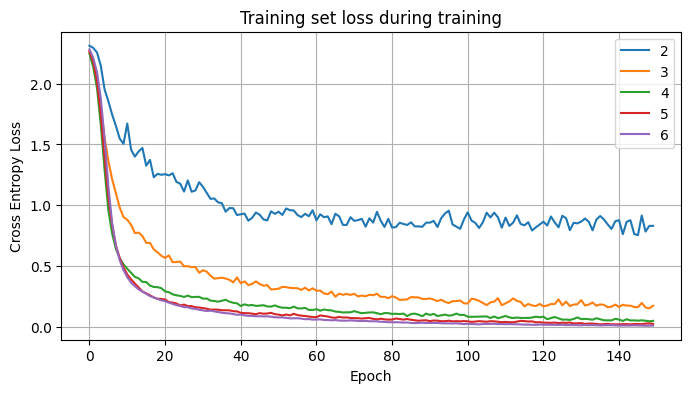

In [4]:
torch.manual_seed(42)


def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)


# Create the tiny CNN with 10 output classes
N_EPOCHS = 150

# Create a train data loader
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

# Create a test data loader to supply batches for network evaluation (test)
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset)

nets = []
bit_range = range(2, 7)

# Train the network with Adam, output the test set accuracy every epoch
losses = []
for n_bits in bit_range:
    net = TinyCNN(10, n_bits)
    losses_bits = []
    optimizer = torch.optim.Adam(net.parameters())
    for _ in tqdm(range(N_EPOCHS), desc=f"Training with {n_bits} bit weights and activations"):
        losses_bits.append(train_one_epoch(net, optimizer, train_dataloader))
    losses.append(losses_bits)

    # Finally, disable pruning (sets the pruned weights to 0)
    net.toggle_pruning(False)
    nets.append(net)

fig = plt.figure(figsize=(8, 4))
for losses_bits in losses:
    plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.legend(list(map(str, bit_range)))
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

### Test the torch network in fp32

In [5]:
def test_torch(net, n_bits, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy for {n_bits}-bit weights and activations: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


for idx, net in enumerate(nets):
    test_torch(net, bit_range[idx], test_dataloader)

Test accuracy for 2-bit weights and activations: 73.11%
Test accuracy for 3-bit weights and activations: 91.56%
Test accuracy for 4-bit weights and activations: 95.11%
Test accuracy for 5-bit weights and activations: 96.44%
Test accuracy for 6-bit weights and activations: 96.67%


### Define the Concrete ML testing function

We introduce the `test_with_concrete` function which allows us to test a Concrete ML model in one of two modes:
- in FHE
- in the clear, using simulated FHE execution

Note that it is trivial to toggle between between the two modes. 

In [6]:
def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        # Accumulate the ground truth labels
        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)

### Test the network using Simulation

Note that this is not a test in FHE. The simulated FHE mode gives 
insight into the number of accumulator bits that are needed and the 
impact of FHE execution on the accuracy.

The torch/brevitas neural network is quantized during training and, for inference, it is converted 
to FHE by Concrete ML using a dedicated function, `compile_brevitas_qat_model`.

In this test we determine the accuracy and accumulator bit-widths for the various quantization settings
that are trained above.

In [7]:
accs = []
accum_bits = []
sim_time = []


for idx in range(len(bit_range)):
    q_module = compile_brevitas_qat_model(nets[idx], x_train)

    accum_bits.append(q_module.fhe_circuit.graph.maximum_integer_bit_width())

    start_time = time.time()
    accs.append(
        test_with_concrete(
            q_module,
            test_dataloader,
            use_sim=True,
        )
    )
    sim_time.append(time.time() - start_time)

for idx, vl_time_bits in enumerate(sim_time):
    print(
        f"Simulated FHE execution for {bit_range[idx]} bit network: {vl_time_bits:.2f}s, "
        f"{len(test_dataloader) / vl_time_bits:.2f}it/s"
    )

100%|██████████| 450/450 [00:00<00:00, 505.95it/s]

Simulated FHE execution for 2 bit network: 0.88s, 511.38it/s
Simulated FHE execution for 3 bit network: 0.90s, 501.12it/s
Simulated FHE execution for 4 bit network: 0.88s, 511.19it/s
Simulated FHE execution for 5 bit network: 0.88s, 511.87it/s
Simulated FHE execution for 6 bit network: 0.89s, 504.99it/s


### Analysis of quantized results

We plot the accuracies obtained for various levels of quantization of weights and activations. 
In addition, we plot the maximum accumulator bit width required to run inference of the network for
each weight and activation bit width. This is shown as the numbers next to the graph markers. 

This accumulator bit width is determined by the compiler and is an important quantity in designing FHE-compatible neural networks.

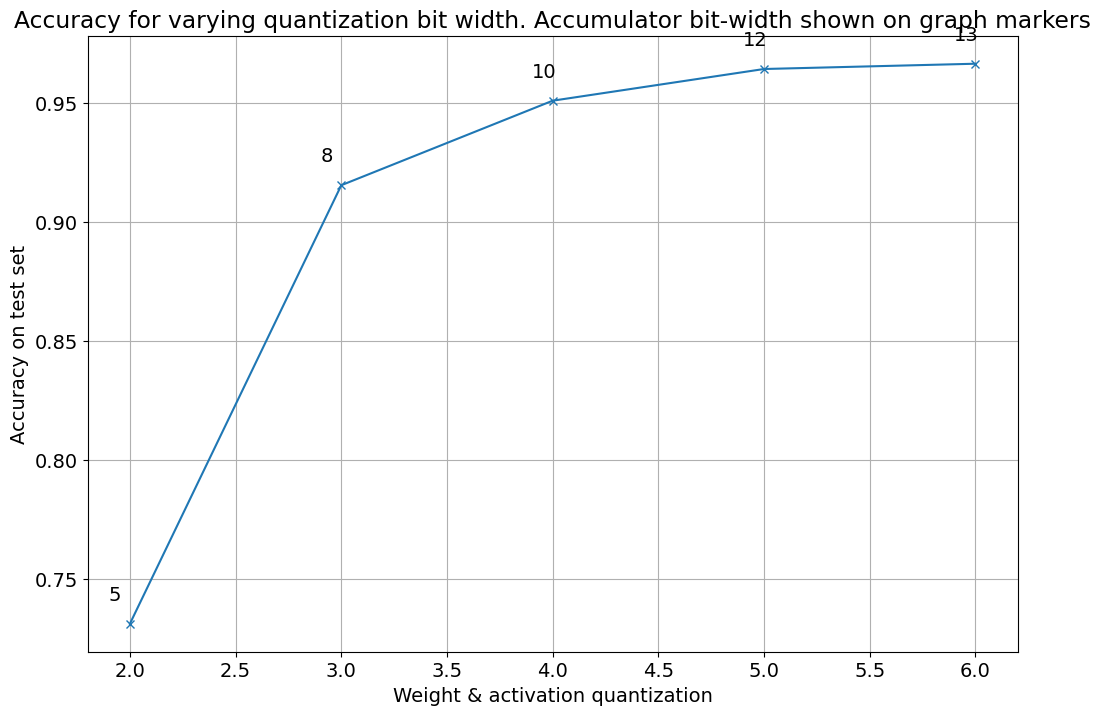

In [8]:
fig = plt.figure(figsize=(12, 8))
plt.rcParams["font.size"] = 14
plt.plot(bit_range, accs, "-x")
for bits, acc, accum in zip(bit_range, accs, accum_bits):
    plt.gca().annotate(str(accum), (bits - 0.1, acc + 0.01))
plt.ylabel("Accuracy on test set")
plt.xlabel("Weight & activation quantization")
plt.grid(True)
plt.title(
    "Accuracy for varying quantization bit width. Accumulator bit-width shown on graph markers"
)
plt.show()

### Test the CNN in FHE

We identify 3 bit weights and activations as a good compromise for which the maximum accumulator size
is low but the accuracy is acceptable. We can now compile to FHE and execute on encrypted data.

### 1. Compile to FHE

In [9]:
bits_for_fhe = 3
idx_bits_fhe = bit_range.index(bits_for_fhe)

accum_bits_required = accum_bits[idx_bits_fhe]

q_module_fhe = None

net = nets[idx_bits_fhe]

q_module_fhe = compile_brevitas_qat_model(
    net,
    x_train,
)

### 2. Generate Keys

In [10]:
# Generate keys first, this may take some time (up to 30min)
t = time.time()
q_module_fhe.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")

Keygen time: 94.13s


### 3. Execute in FHE on encrypted data

In [11]:
# Run inference in FHE on a single encrypted example
mini_test_dataset = TensorDataset(torch.Tensor(x_test[[0], :]), torch.Tensor(y_test[[0]]))
mini_test_dataloader = DataLoader(mini_test_dataset)

t = time.time()
test_with_concrete(
    q_module_fhe,
    mini_test_dataloader,
    use_sim=False,
)
print(f"Time per inference in FHE: {(time.time() - t) / len(mini_test_dataset):.2f}")

100%|██████████| 1/1 [00:26<00:00, 26.25s/it]

Time per inference in FHE: 26.25


### Conclusion

We see that quantization with **3** bit weight and activations is the best viable FHE configuration,
as the accumulator bit width for this configuration is between **7 and 8** bits (can vary due to the final 
distribution of the weights). The accuracy in this setting, 92% is a few percentage points 
under the maximum accuracy achievable with larger accumulator bit widths (97-98%). 

Compiling the higher bit-width networks is also possible, but in this example, to ensure FHE execution is fast
we used the lower bit-width quantization setting.
